<a href="https://colab.research.google.com/github/nester256/test_tf/blob/2/2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт пакетов

In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузка данных из [Muffin vs ChiHuaHua](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification)




In [3]:
zip_file = '/content/drive/My Drive/archive.zip'
extracted_dir_path = 'archive'

drive.mount('/content/drive')

os.makedirs(extracted_dir_path, exist_ok=True)    # Создание директории, если её нет
z = zipfile.ZipFile(zip_file, 'r')
z.extractall(extracted_dir_path)                  # Распаковываем архив в ресурсы нашего блокнота

Mounted at /content/drive


Набор данных, который мы загрузили, имеет следующую структуру:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>archive</b>
|__ <b>train</b>
    |______ <b>chihuahua</b>: [img.0.jpg, img.1.jpg, img.2.jpg ...]
    |______ <b>muffin</b>: [img.0.jpg, img.1.jpg, img.2.jpg ...]
|__ <b>test</b>
    |______ <b>chihuahua</b>: [img.2000.jpg, img.2001.jpg, img.2002.jpg ...]
    |______ <b>muffin</b>: [img.2000.jpg, img.2001.jpg, img.2002.jpg ...]
</pre>

Получаем полный список директорий следующей командой:

In [4]:
dir_base = os.path.dirname(extracted_dir_path)
!find $dir_base -type d -print

.
./.config
./.config/logs
./.config/logs/2023.12.19
./.config/configurations
./archive
./archive/test
./archive/test/chihuahua
./archive/test/muffin
./archive/train
./archive/train/chihuahua
./archive/train/muffin
./drive
./drive/.shortcut-targets-by-id
./drive/MyDrive
./drive/MyDrive/Colab Notebooks
./drive/.file-revisions-by-id
./drive/.Trash-0
./drive/.Trash-0/files
./drive/.Trash-0/info
./sample_data



Теперь присваиваем переменным корректные пути к директориям с наборами данных для тренировки и валидации:

In [8]:
base_dir = os.path.join(os.path.dirname(extracted_dir_path), 'archive')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_chihuahua_dir = os.path.join(train_dir, 'chihuahua')
train_muffin_dir = os.path.join(train_dir, 'muffin')
validation_chihuahua_dir = os.path.join(validation_dir, 'chihuahua')
validation_muffin_dir = os.path.join(validation_dir, 'muffin')

In [12]:
num_chihuahua_tr = len(os.listdir(train_chihuahua_dir))
num_muffin_tr = len(os.listdir(train_muffin_dir))

num_chihuahua_val = len(os.listdir(validation_chihuahua_dir))
num_muffin_val = len(os.listdir(validation_muffin_dir))

total_train = num_chihuahua_tr + num_muffin_tr
total_val = num_chihuahua_val + num_muffin_val

print('Чихуахуа в обучающем наборе данных: ', num_chihuahua_tr)
print('Мафиионов в обучающем наборе данных: ', num_muffin_tr)

print('Чихуахуа в валидационном наборе данных: ', num_chihuahua_val)
print('Мафиионов в валидационном наборе данных: ', num_muffin_val)
print('--')
print('Всего изображений в тренировочном наборе данных: ', total_train)
print('Всего изображений в валидационном наборе данных: ', total_val)

Чихуахуа в обучающем наборе данных:  2559
Мафиионов в обучающем наборе данных:  2174
Чихуахуа в валидационном наборе данных:  640
Мафиионов в валидационном наборе данных:  544
--
Всего изображений в тренировочном наборе данных:  4733
Всего изображений в валидационном наборе данных:  1184


Устанавливаем параметры модели

In [15]:
BATCH_SIZE = 100  # количество тренировочных изображений для обработки перед обновлением параметров модели
IMG_SHAPE = 150 # размерность к которой будет преведено входное изображение

Перед тем как изображения могут быть использованы в качестве входных данных для нашей сети их необходимо преобразовать к тензорам со значениями с плавающей запятой. Список шагов, которые необходимо предпринять для этого:

1. Прочитать изображения с диска
2. Декодировать содержимое изображений и преобразовать в нужный формат с учетом RGB-профиля
3. Преобразовать к тензорам со значениями с плавающей запятой
4. Произвести нормализацию значений тензора из интервала от 0 до 255 к интервалу от 0 до 1, так как нейронные сети лучше работают с маленькими входными значениями.

К счастью все эти операции могут быть выполнены с использованием `tf.keras.preprocessing.image.ImageDataGenerator`-класса.

Всё это мы можем делаем с использованием этих строк кода:

In [13]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

После того как мы определили генераторы для набора тестовых и валидационных данных, метод **flow_from_directory** загрузит изображения с диска, нормализует данные и изменит размер изображений - всего лишь одной строкой кода:

In [16]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                          class_mode='binary')

Found 4733 images belonging to 2 classes.


In [17]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')

Found 1184 images belonging to 2 classes.


Визуализируем изображения из тренировочного набора данных воспользовавшись `matplotlib`:

In [18]:
sample_training_images, y = next(train_data_gen)

Функция next возвращает блок изображений из набора данных. Один блок представляет собой кортеж из (множество изображений, множество меток). В данный момент мы отбросим метки, так как они нам не нужны - нас интересуют сами изображения.

In [19]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

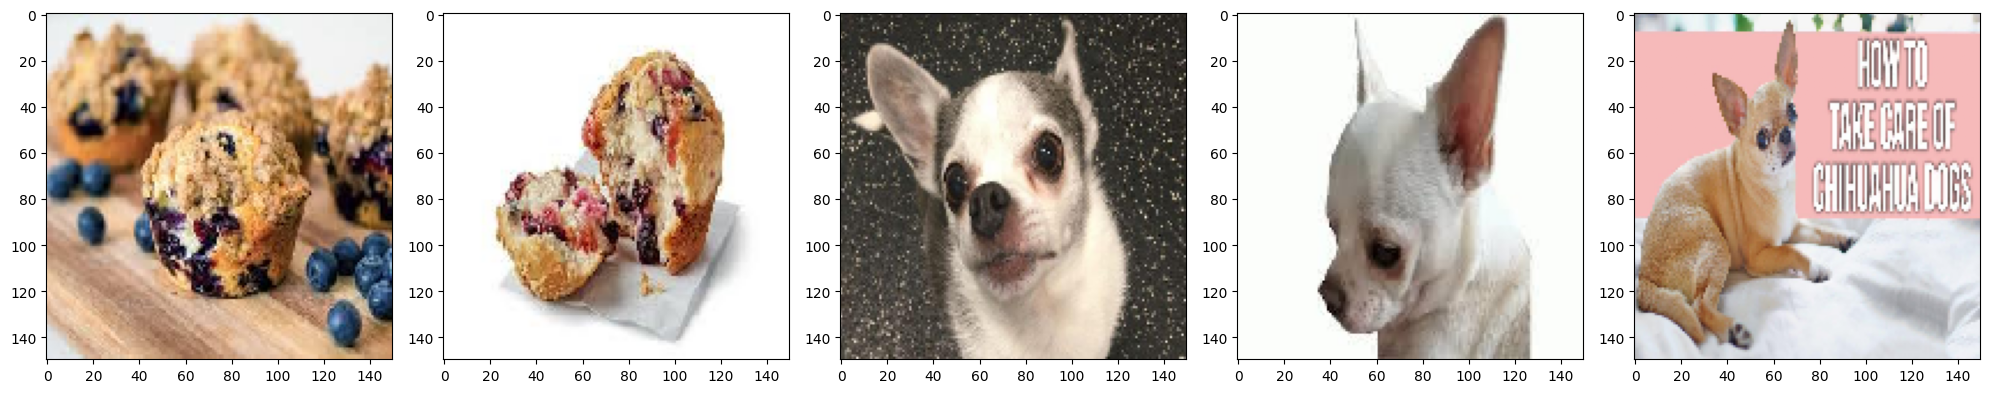

In [20]:
plotImages(sample_training_images[:5])

Модель состоит из 4 блоков свёртки после каждого из которых следует блок со слоем подвыборки. Далее у нас идёт полносвязный слой с 512 нейронами и функцией активации `relu`. Модель выдаст распределение вероятностей по двум классам - собаки и кошки - используя `softmax`.

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

Компилирование модели. Как и ранее мы воспользуемся оптимизатором `adam`. В качестве функции потерь воспользуемся `binary_crossentropy`. Так же мы хотим на каждой обучающей итерации следить за точностью модели, поэтому передаём значение `accuracy` в параметр `metrics`:

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Представление модели. Взглянем на структуру нашей модели по уровням используя метод **summary**:

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

Тренировка модели.
Так как обучающие блоки будут поступать из генератора (ImageDataGenerator) мы воспользуемся методом fit_generator вместо ранее используемого метода fit:

In [25]:
history = model.fit_generator(
    train_data_gen,
    epochs=10,
    validation_data=val_data_gen)

<ipython-input-25-9f8c81b85bde>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
48/48 [==============================] - 192s 4s/step - loss: 0.5580 - accuracy: 0.7010 - val_loss: 0.3943 - val_accuracy: 0.8184
Epoch 2/10
48/48 [==============================] - 173s 4s/step - loss: 0.3822 - accuracy: 0.8312 - val_loss: 0.3785 - val_accuracy: 0.8319
Epoch 3/10
48/48 [==============================] - 163s 3s/step - loss: 0.3190 - accuracy: 0.8673 - val_loss: 0.2803 - val_accuracy: 0.8885
Epoch 4/10
48/48 [==============================] - 170s 4s/step - loss: 0.2828 - accuracy: 0.8844 - val_loss: 0.3217 - val_accuracy: 0.8623
Epoch 5/10
48/48 [==============================] - 168s 4s/step - loss: 0.2633 - accuracy: 0.8918 - val_loss: 0.2428 - val_accuracy: 0.9012
Epoch 6/10
48/48 [==============================] - 167s 3s/step - loss: 0.2379 - accuracy: 0.8999 - val_loss: 0.2556 - val_accuracy: 0.8868
Epoch 7/10
48/48 [==============================] - 172s 4s/step - loss: 0.2028 - accuracy: 0.9172 - val_loss: 0.2890 - val_accuracy: 0.8826
Epoch 8/10
48

Визуализация результатов тренировки.

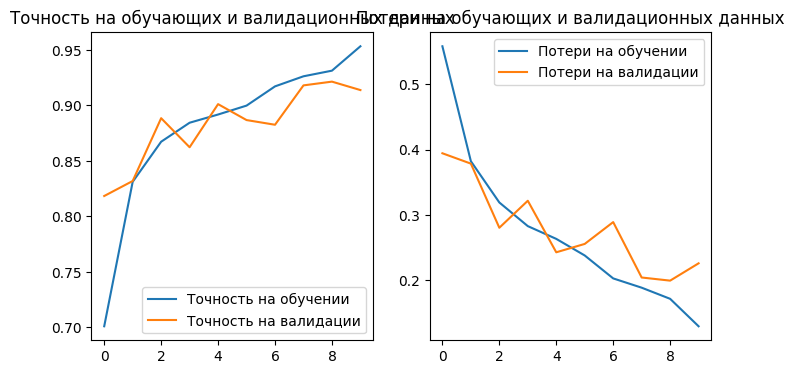

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')
plt.title('Точность на обучающих и валидационных данных')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Потери на обучающих и валидационных данных')
plt.savefig('./foo.png')
plt.show()

In [28]:
test_images, y = next(val_data_gen)
class_names = [ "чихуахуа",  "маффин"]
y_pred=model.predict(test_images)

4/4 [==============================] - 2s 326ms/step


Берем случайное изображение из тестовой выборки:

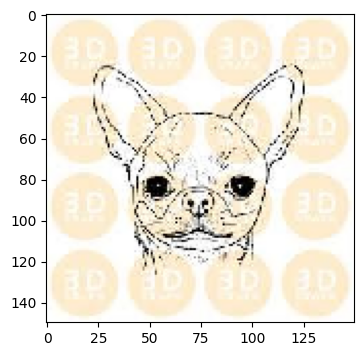

In [29]:
plt.figure(figsize=(4,4))
plt.imshow(test_images[50])

In [30]:
k=round(y_pred[50][0])
class_names[k]

'чихуахуа'